In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import pylab
import matplotlib.pyplot as plt
import time
import matplotlib
import sys
import tqdm
import scipy

from sot.core import mocklc
from sot.core import sepmat
from sot.core import mvmap
from sot.dymap import gpkernel
from sot.dymap import rundynamic_cpu as rd
from sot.sotplot import plotdymap


In [3]:
    fontsize=16
    matplotlib.rcParams.update({'font.size':fontsize})
    np.random.seed(53)

    #set geometry                                                               
    inc=45.0/180.0*np.pi
    Thetaeq=np.pi
    zeta=23.4/180.0*np.pi
    Pspin=23.9344699/24.0 #Pspin: a sidereal day                                
    wspin=2*np.pi/Pspin
    Porb=365.242190402
    worb=2*np.pi/Porb                                                          \

    Ni=1024
    obst=np.linspace(0.0,Porb,Ni)

    # test moving map                                                           
    nside=16
    npix=hp.nside2npix(nside)

NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Weight 0.3400094509124756 sec
Lc 0.3511688709259033 sec


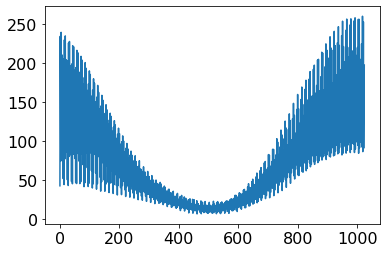

In [4]:
    mmap=hp.read_map("/home/kawahara/exomap/sot/data/mockalbedo16.fits")
    mask=(mmap>0.0)
    mmap[mask]=1.0
    M=mvmap.rotating_map(mmap,obst,rotthetamax=np.pi/2.0)
    #geometric weight                                                           
    ts=time.time()
    Thetav=worb*obst
    Phiv=np.mod(wspin*obst,2*np.pi)
    WI,WV=mocklc.comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv)
    W=WV[:,:]*WI[:,:]
    print("Weight",time.time()-ts,"sec")

    #Light curve                                                                
    lc=np.sum(W*M,axis=1)
    noiselevel=0.01
    sigma=noiselevel*np.mean(lc)
    noise=sigma*np.random.normal(0.0,1.0,np.shape(lc))
    lc=lc+noise
    print("Lc",time.time()-ts,"sec")
    plt.plot(lc)
    

  0%|          | 0/3 [00:00<?, ?it/s]

No title or mismatch


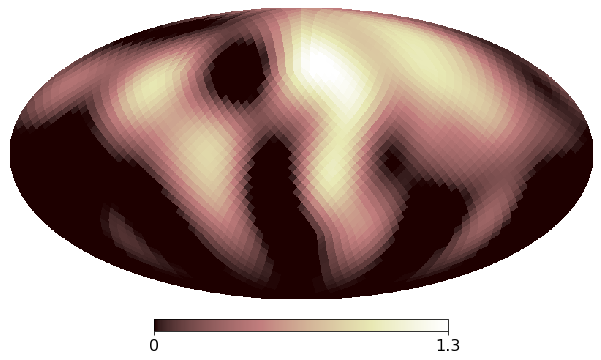

 33%|███▎      | 1/3 [00:00<00:00,  5.43it/s]

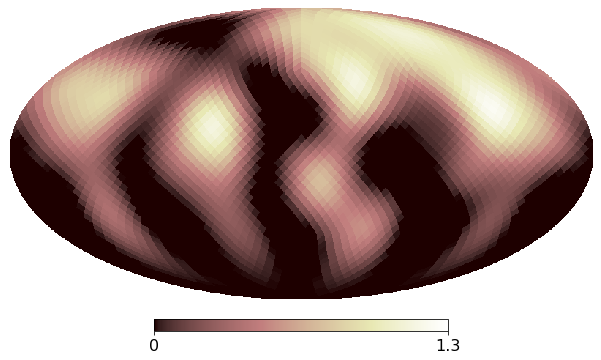

 67%|██████▋   | 2/3 [00:00<00:00,  5.81it/s]

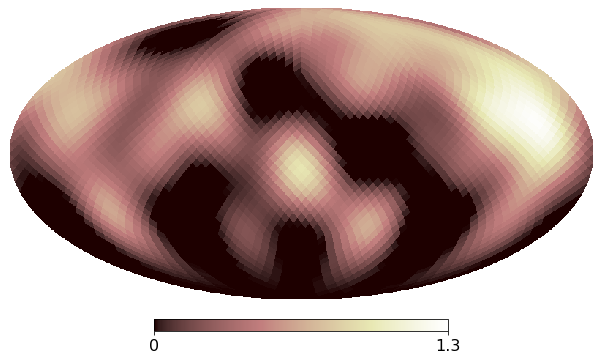

100%|██████████| 3/3 [00:00<00:00,  6.20it/s]


In [5]:
    tau=360.0
    gamma=16.5/180.0*np.pi
    sep=sepmat.calc_sepmatrix(nside)
    KS=gpkernel.RBF(sep,gamma)
    KT=gpkernel.Matern32(obst,tau)
    alpha=0.25
    Pid=np.eye(Ni)*sigma**-2
    Mast=rd.Mean_DYSOT(W,KS,KT,alpha,lc,Pid)

    frames=[0,int(Ni/2),Ni-1]
    plotdymap.plotseqmap(Mast,frames,"mapest","",vmin=0.0,vmax=1.3,pdf=False,png=False,show=True)
